In [321]:
import os
import tarfile
import urllib

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor


## Downloading the Data

Fetching California Housing data from the Github Repository

In [183]:
DOWNLOAD_ROOT="https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL=DOWNLOAD_ROOT+HOUSING_PATH+"/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path=os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz=tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data(HOUSING_URL,HOUSING_PATH)

In [184]:
csv_path=os.path.join(HOUSING_PATH,"housing.csv")

## Preliminary Analysis

Getting a better grasp of the data and metadata.

In [185]:
housing = pd.read_csv(csv_path)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [186]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The ocean_proximity column is categorical, as evidenced by the fact that it has the object data type. From the head() function, it can be seen that there exists at least 1 category: "Near Bay".

We can find the other categories.

In [187]:
housing["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [188]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


As the data set is comprised on 20640 rows, and there are only 20433 data points for the total_bedrooms column, there are a total of 207 data points missing.

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

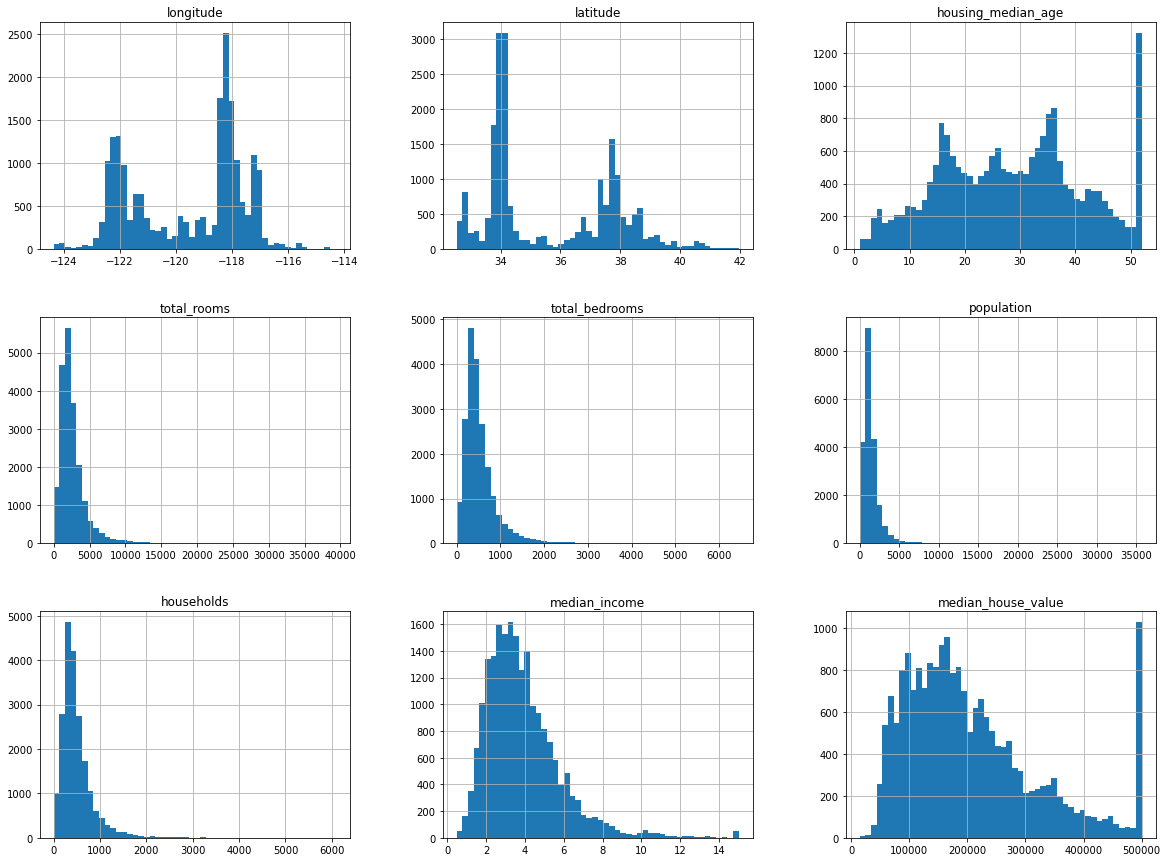

In [189]:
housing.hist(bins=50, figsize = (20,15))

### Key points

1. Medium income attribute is in $10,000 USD, and has been capped between 0.4999 and 15.0001
2. The housing median age and the median house value attributes have also been capped at a max, as evidenced by the large bar at the end of each of the histographs.
3. Many of the attributes have tails, this will make it difficult for machine learning algorithms to identify a pattern.

## Splitting Test & Train Data

In [191]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

<AxesSubplot:>

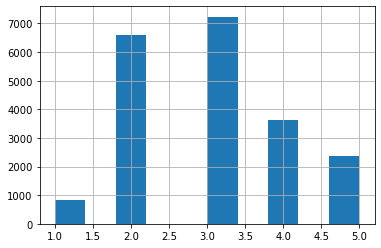

In [190]:
housing["income_categories"] = pd.cut(housing["median_income"],bins=[0.,1.5,3.0,4.5,6., np.inf],labels=[1,2,3,4,5])
housing["income_categories"].hist()

In [194]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_categories"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [198]:
strat_test_set["income_categories"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_categories, dtype: float64

In [200]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_categories", axis=1, inplace=True)

In [201]:
housing = strat_train_set.copy()

## Visualisations

Obtaining an in depth analysis of the data.

/Users/ishanamin/opt/anaconda3/envs/Tensor/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

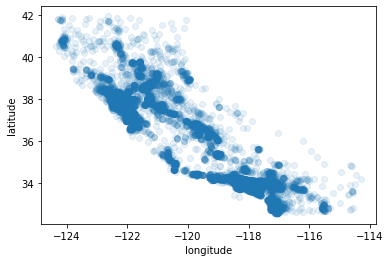

In [202]:
sb.regplot('longitude','latitude', data = housing,scatter=True, fit_reg = False, scatter_kws={'alpha':0.1})

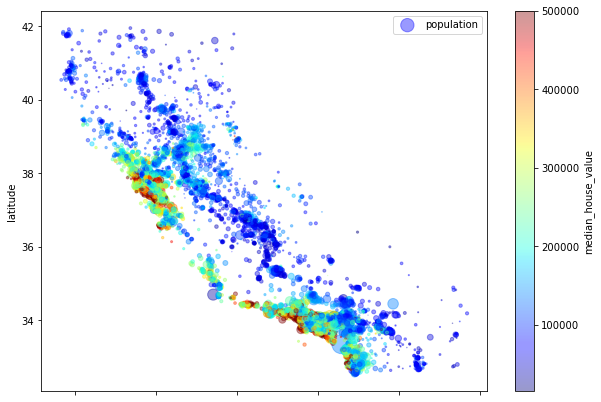

In [203]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=housing["population"]/100, label="population", figsize=(10,7),
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

This indicates that houses closer to the ocean are more expensive compared to those farther away from the ocean.

In [204]:
corr_matrix = housing.corr()
housing.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


<AxesSubplot:>

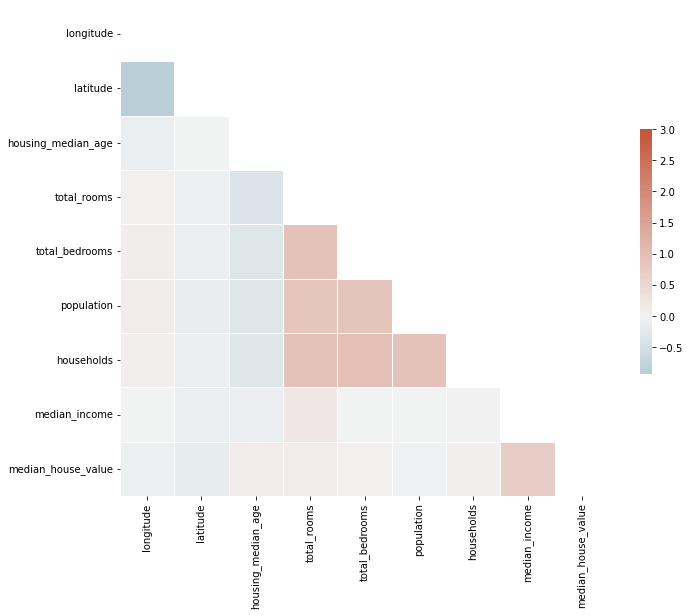

In [206]:
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

f, ax = plt.subplots(figsize=(11,9))
cmap = sb.diverging_palette(230,20, as_cmap=True)
sb.heatmap(corr_matrix, mask = mask, cmap=cmap,vmax=3,center=0,
square = True, linewidths = 0.5, cbar_kws={'shrink':0.5})

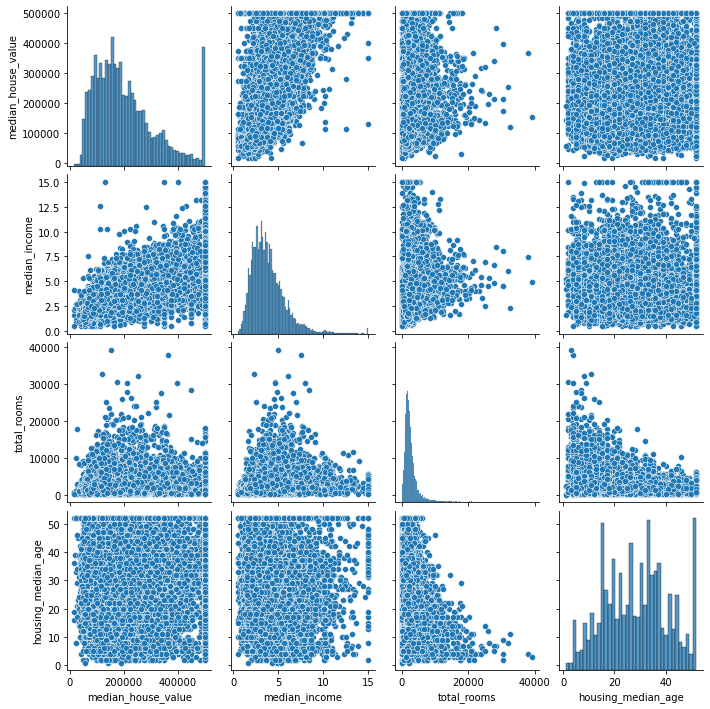

In [177]:
sb.pairplot(housing[['median_house_value','median_income','total_rooms','housing_median_age']])

/Users/ishanamin/opt/anaconda3/envs/Tensor/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

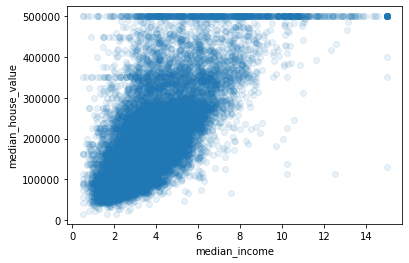

In [207]:
sb.regplot('median_income','median_house_value',data=housing, scatter=True, fit_reg=False, scatter_kws={'alpha':0.1})

## Attribute Combinations

In [208]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [210]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

## Preparing for Machine Learning Algorithm

### Data Cleaning

In [315]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [295]:
housing_labels

<bound method NDFrame.copy of 12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
           ...   
15174    268500.0
12661     90400.0
19263    140400.0
19140    258100.0
19773     62700.0
Name: median_house_value, Length: 16512, dtype: float64>

As mentioned earlier, total bedrooms has some missing features. Most machine learning algorithms can't work with missing values, and so we can remove the rows with the missing values

In [296]:
housing.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,INLAND
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,<1H OCEAN


In [297]:
imputer = SimpleImputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [298]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [299]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [300]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X,columns=housing_num.columns,index=housing_num.index)
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


### Handling Text and Categorical Attributes

In [301]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [304]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([1, 4, 1, ..., 0, 0, 1])

In [305]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [306]:
from sklearn.preprocessing import LabelBinarizer
cat_encoder = LabelBinarizer()
housing_cat_1hot=cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]])

## Custom Transformer

In [307]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Transformation Pipelines

In [308]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
 ])
housing_num_tr = num_pipeline.fit_transform(housing_num)

from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
 ])


In [309]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 16)

In [319]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

68627.87390018745

In [329]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [332]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring= "neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)


In [333]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

In [334]:
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180657


In [335]:
display_scores(tree_rmse_scores)

Scores: [70747.73485138 70576.74356674 68064.46226054 70095.39355747
 68306.35828288 78463.63687097 69256.71233309 75159.39337836
 67245.31148485 71266.67555722]
Mean: 70918.24221434924
Standard deviation: 3272.3328513464567


In [336]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18647.451417268127

In [338]:
forest_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring= "neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180657


## Grid Search
Fine Tuning the model

In [339]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 ]
 
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [341]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [342]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [344]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

62249.737694357806 {'max_features': 2, 'n_estimators': 3}
55369.585325578046 {'max_features': 2, 'n_estimators': 10}
52629.358424632985 {'max_features': 2, 'n_estimators': 30}
60348.85588579333 {'max_features': 4, 'n_estimators': 3}
52655.07938598452 {'max_features': 4, 'n_estimators': 10}
50199.393869409556 {'max_features': 4, 'n_estimators': 30}
58786.12915468151 {'max_features': 6, 'n_estimators': 3}
52408.3301509189 {'max_features': 6, 'n_estimators': 10}
50123.036304019675 {'max_features': 6, 'n_estimators': 30}
58716.75059140314 {'max_features': 8, 'n_estimators': 3}
51703.54166080997 {'max_features': 8, 'n_estimators': 10}
50284.23841099727 {'max_features': 8, 'n_estimators': 30}
62768.85241270126 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54400.24526477715 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59216.62919287718 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52733.78411853776 {'bootstrap': False, 'max_features': 3, 'n_estimators'

## Evaluating on the Test Set

In [346]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48490.04950970454